# Datensatz zum Training und Testen vorbereiten

In [19]:
folder = "imagenette2_320px/"

import torch
from torchvision import datasets, transforms

# Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()    
])

# Trainings- und Testdatensatz vorbereiten
train_dataset = datasets.ImageFolder(root=f"{folder}/train",
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True)

test_dataset = datasets.ImageFolder(root=f"{folder}/val",
                                    transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False)

In [3]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9501
    Root location: imagenette2_320px//train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [4]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 3925
    Root location: imagenette2_320px//val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

# Anzahl der Batches pro Epoche anzeigen

In [ ]:
nr_batches = 0
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    nr_batches += 1
print("nr_batches", nr_batches)

In [6]:
len(train_dataset)

9501

In [7]:
len(train_loader)

297

In [8]:
train_loader.batch_size

32

In [9]:
len(train_dataset) / train_loader.batch_size

296.90625

In [10]:
9501 % 32

29

In [11]:
29/32

0.90625

# CNN-Modell in PyTorch definieren

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1   = nn.Linear(64*28*28, 512)
        self.fc2   = nn.Linear(512, 10) # 10 Klassen

    def forward(self, x):

        # Merkmalshierarchie
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Übergang zum MLP
        x = F.flatten(x)
        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # absichtlich: keine Relu hier!  

        return x
        

In [13]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

# Alternative Definition des CNN-Modells ohne `functional`-Modul 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.relu3 = nn.ReLU()

        self.flatten1 = nn.Flatten()
        
        self.fc1   = nn.Linear(64*28*28, 512)
        self.relu4 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10) # 10 Klassen

    def forward(self, x):

        # Merkmalshierarchie
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Übergang zum MLP
        x = self.flatten1(x)
        # MLP
        x = self.relu4(self.fc1(x))
        x = self.fc2(x) # absichtlich: keine Relu hier!  

        return x
        

In [11]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=78400, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [9]:
from torchsummary import summary
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 25,719,338
Trainable para

# Automatische Ermittelung der Zahl 64x28x28

In [16]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)       
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        # Benutzen Sie einen Dummy-Eingabedatensatz, um die Größe automatisch zu ermitteln
        with torch.no_grad():
            self._initialize_fc_layers(torch.rand(1, 3, 224, 224))

    def _initialize_fc_layers(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        print("x.size=",x.size())
        n_size = x.size(1)
        print("n_size=",n_size)
        self.fc1   = nn.Linear(n_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Übergang zum MLP
        x = self.flatten(x)

        # MLP        
        x = self.relu4(self.fc1(x))        
        x = self.fc2(x)

        # Output-Tensor zurückliefern
        return x

model = SimpleCNN()
model

x.size= torch.Size([1, 50176])
n_size= 50176


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [17]:
from torchsummary import summary
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 25,719,338
Trainable para

# CNN erstellen und auf der CPU trainieren

In [ ]:
import torch.optim as optim

model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
model.train()

for epoch in range(1,num_epochs+1):
    print(f"Trainings-Epoche: {epoch}/{num_epochs}")

    batch_nr = 1
    for images, labels in train_loader:
        if batch_nr % 25 == 0:
            print(f"\tBatch: {batch_nr}")
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_nr += 1

# Ist eine GPU verfügbar?

In [22]:
torch.cuda.is_available()

True

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cuda')

# Jetzt geht es auf die GPU

x.size= torch.Size([1, 50176])
n_size= 50176
Trainings-Epoche: 1/2
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Trainings-Epoche: 2/2
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275


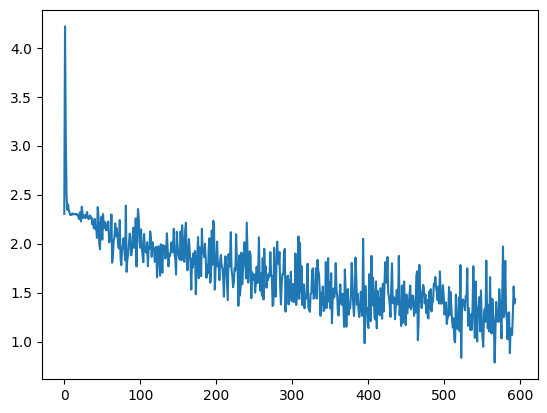

In [32]:
import torch.optim as optim

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
model.train()

losses = []

for epoch in range(1,num_epochs+1):
    print(f"Trainings-Epoche: {epoch}/{num_epochs}")

    batch_nr = 1
    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        
        if batch_nr % 25 == 0:
            print(f"\tBatch: {batch_nr}")
        outputs = model(images)

        loss = criterion(outputs, labels)
        losses.append( loss.item() )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_nr += 1

import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()